##**Import Packages** 

In [72]:
import numpy as np
import tensorflow as tf
import pandas as pd
import os
import matplotlib.pyplot as plt
import re
import wordcloud
from wordcloud import WordCloud
from sklearn import utils

##**Load the data**

In [73]:
train_data=pd.read_csv(os.path.join('drive/MyDrive/deep_learning_projects/toxic_comments_classifier/data/train.csv'))
test_data=pd.read_csv(os.path.join('drive/MyDrive/deep_learning_projects/toxic_comments_classifier/data/test.csv'))

##**Data Analysis and visualization**

In [74]:
print(train_data.shape)
print(test_data.shape)


(159571, 8)
(153164, 2)


In [75]:
train_data.head(20)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [76]:
test_data.head(5)  #it for evaluation by kaggle

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [77]:
train_data.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [78]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [79]:
#print some comments for insights
def print_insights(x):
    for i in range(10):
        print(f'{i+1} :{x[i]}')
        print('\n')
print_insights(train_data['comment_text'])

1 :Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27


2 :D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)


3 :Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.


4 :"
More
I can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on r

In [80]:
#print value counts for all columns
for i in train_data.columns[2:]:
    print(f'{i}')
    print(f'{train_data[i].value_counts()}')
    print('\n')

toxic
0    144277
1     15294
Name: toxic, dtype: int64


severe_toxic
0    157976
1      1595
Name: severe_toxic, dtype: int64


obscene
0    151122
1      8449
Name: obscene, dtype: int64


threat
0    159093
1       478
Name: threat, dtype: int64


insult
0    151694
1      7877
Name: insult, dtype: int64


identity_hate
0    158166
1      1405
Name: identity_hate, dtype: int64




In [81]:
#another way of value count for each column
data_count=train_data.iloc[:,2:].sum()
def print_value_count():
    print(data_count)
    print(list(data_count.keys()))
    print(list(data_count.values))

print_value_count()

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64
['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
[15294, 1595, 8449, 478, 7877, 1405]


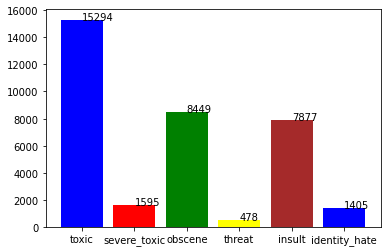

In [82]:
#plot in bar graph
def plot_bar(x,y):
    plt.bar(x,y,color=['blue','red','green','yellow','brown'])
    for i in range(len(x)):
        plt.text(i,y[i],y[i])
        
plot_bar(list(data_count.keys()),list(data_count.values))

##**Preprocess the data**

In [83]:
#substitute all alphanumberic values with space
remove_alnum=lambda x: re.sub('\w*\d\w*','',x)  #match the words with regex sequence

#convert into lower case
to_lower=lambda x: x.lower()

#substitute all '\n' with the space
remove_newline=lambda x: re.sub('\n',' ', x)

train_data['comment_text']=train_data['comment_text'].map(remove_alnum).map(to_lower).map(remove_newline)

In [84]:
print_insights(train_data['comment_text'])

1 :explanation why the edits made under my username hardcore metallica fan were reverted? they weren't vandalisms, just closure on some gas after i voted at new york dolls fac. and please don't remove the template from the talk page since i'm retired now....


2 :d'aww! he matches this background colour i'm seemingly stuck with. thanks.  (talk) :, january ,  (utc)


3 :hey man, i'm really not trying to edit war. it's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. he seems to care more about the formatting than the actual info.


4 :" more i can't make any real suggestions on improvement - i wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -i think the references may need tidying so that they are all in the exact same format ie date format etc. i can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want t

In [85]:
def preprocess_text(txt):
    x=txt.split()
    processed=[]
    for i in x:
        p=re.findall("[a-zA-Z,.!-']*",i)
        s=" ".join(p)
        s=re.sub('\s+','',s)
        processed.append(s)
    return " ".join(processed)

train_data['comment_text']=train_data['comment_text'].map(preprocess_text)
print_insights(train_data['comment_text'])

1 :explanation why the edits made under my username hardcore metallica fan were reverted they weren't vandalisms, just closure on some gas after i voted at new york dolls fac. and please don't remove the template from the talk page since i'm retired now....


2 :d'aww! he matches this background colour i'm seemingly stuck with. thanks. talk , january , utc


3 :hey man, i'm really not trying to edit war. it's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. he seems to care more about the formatting than the actual info.


4 :" more i can't make any real suggestions on improvement  i wondered if the section statistics should be later on, or a subsection of ""types of accidents"" i think the references may need tidying so that they are all in the exact same format ie date format etc. i can do that later on, if noone else does first  if you have any preferences for formatting style on references or want to do it yours

##**Create word cloud to see words in each category apearning the most**

####**Create 6 separate datasets for each category**

In [86]:
train_data.head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0
1,000103f0d9cfb60f,d'aww! he matches this background colour i'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"hey man, i'm really not trying to edit war. it...",0,0,0,0,0,0
3,0001b41b1c6bb37e,""" more i can't make any real suggestions on im...",0,0,0,0,0,0
4,0001d958c54c6e35,"you, sir, are my hero. any chance you remember...",0,0,0,0,0,0


In [87]:
data_toxic=train_data.iloc[:,:3]

In [88]:
data_sevtoxic=train_data.loc[:,['id','comment_text','severe_toxic']]

In [89]:
data_obscene=train_data.loc[:,['id','comment_text','obscene']]

In [90]:
data_threat=train_data.loc[:,['id','comment_text','threat']]

In [91]:
data_insult=train_data.loc[:,['id','comment_text','insult']]

In [92]:
data_idhate=train_data.loc[:,['id','comment_text','identity_hate']]

####**Create word cloud**

In [93]:
# datase=data_toxic[data_toxic['toxic']==1].comment_text

In [94]:
def wordcloud(dataset,label):
    text=dataset[dataset[label]==1].comment_text.values  #creates list of all sentences of one label of comment
    wc=WordCloud().generate(' '.join(text))   #.join() here joins all sentences from list by space to a single string
    plt.imshow(wc,interpolation='bilinear')
    plt.axis('off')
    plt.show()

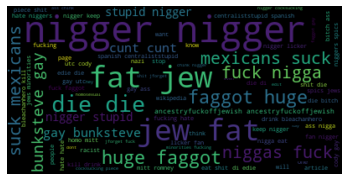

In [95]:
wordcloud(data_idhate,'identity_hate')

##**Create a balanced dataset**

In [96]:
print_value_count()

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64
['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
[15294, 1595, 8449, 478, 7877, 1405]


In [97]:
#balanced data for toxic
data_toxic_0=data_toxic[data_toxic['toxic']==0].iloc[:5000,:]
data_toxic_1=data_toxic[data_toxic['toxic']==1].iloc[:5000,:]
data_toxic_balanced=pd.concat([data_toxic_0,data_toxic_1])
print(data_toxic_balanced.shape)

data_toxic_balanced=utils.shuffle(data_toxic_balanced,random_state=48)
data_toxic_balanced.head(10)

(10000, 3)


,id,comment_text,toxic
398,00fa6072f2eb086b,""" canonicity in general i've been involved in ...",0
40138,6b1fce15f888a487,""" ban my fat ass, bitch! i need an internet br...",1
2207,05ffc9ec106ecd6e,""" smile album rerecording vocals how much it d...",0
1607,044df95de9cc9daa,can you offer advice on how to get the kanji,0
1719,04aa3354e0bff7da,""" creationist category as there are no cites i...",0
18565,30fcf9fc2ff0e679,a wikipedia administrator! nothing more ridicu...,1
44770,779cf821fbd61418,dude... at the end you fucked my article secto...,1
838,024859995cf6379e,thank you for experimenting with wikipedia. yo...,0
37305,6398a98569c2bf37,""" google name origin """"goo ogle"""". stare at t...",1
33200,5864d1bbd9f030d0,what go lick a pig you arab muslim peice of scum.,1


In [98]:
#balanced data for severe_toxic
data_sevtoxic_0=data_sevtoxic[data_sevtoxic['severe_toxic']==0].iloc[:2000,:]
data_sevtoxic_1=data_sevtoxic[data_sevtoxic['severe_toxic']==1]
data_sevtoxic_balanced=pd.concat([data_sevtoxic_0,data_sevtoxic_1])
print(data_sevtoxic_balanced.shape)

data_sevtoxic_balanced=utils.shuffle(data_sevtoxic_balanced,random_state=48)

(3595, 3)


In [99]:
#balanced data for obscene
data_obscene_0=data_obscene[data_obscene['obscene']==0].iloc[:5000,:]
data_obscene_1=data_obscene[data_obscene['obscene']==1].iloc[:5000,:]
data_obscene_balanced=pd.concat([data_obscene_0,data_obscene_1])
print(data_obscene_balanced.shape)

data_obscene_balanced=utils.shuffle(data_obscene_balanced,random_state=48)

(10000, 3)


In [100]:
#balanced data for threat
data_threat_0=data_threat[data_threat['threat']==0].iloc[:1200,:]
data_threat_1=data_threat[data_threat['threat']==1]
data_threat_balanced=pd.concat([data_threat_0,data_threat_1])
print(data_threat_balanced.shape)

data_threat_balanced=utils.shuffle(data_threat_balanced,random_state=48)

(1678, 3)


In [101]:
#balanced data for insult
data_insult_0=data_insult[data_insult['insult']==0].iloc[:5000,:]
data_insult_1=data_insult[data_insult['insult']==1].iloc[:5000,:]
data_insult_balanced=pd.concat([data_insult_0,data_insult_1])
print(data_insult_balanced.shape)

data_insult_balanced=utils.shuffle(data_insult_balanced,random_state=48)

(10000, 3)


In [102]:
#balanced data for identity hate
data_idhate_0=data_idhate[data_idhate['identity_hate']==0].iloc[:2501,:]
data_idhate_1=data_idhate[data_idhate['identity_hate']==1]
data_idhate_balanced=pd.concat([data_idhate_0,data_idhate_1])


data_idhate_balanced=utils.shuffle(data_idhate_balanced,random_state=48)
print(data_idhate_balanced.shape)
data_idhate_balanced.head(5)

(3906, 3)


,id,comment_text,identity_hate
59279,9ecf3329158e0276,jew get the fuck out of here you jewish son of...,1
2252,0617a8b319fde352,""" ola thank you for experimenting with wikiped...",0
1094,02fcd5c28005823d,"yes, i concur most wholeheartedly!! i know the...",0
2168,05deec00d640ca08,i'll extend the hold time.,0
2089,05a6e59c979e05f3,"knock it off! spinningspark, quit it! you've b...",0


##**Model**

In [103]:
!pip install tensorflow_text

In [104]:
import tensorflow_hub as hub
import tensorflow_text as text

In [105]:
preprocessor_url='https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
encoder_url='https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'

bert_preprocess_model=hub.KerasLayer(preprocessor_url)
bert_model=hub.KerasLayer(encoder_url)

In [106]:
#function for returning embedding of sentences
def get_sentence_embedding(sentence):
    text_preprocessed=bert_preprocess_model(sentence)
    
    return bert_model(text_preprocessed)['pooled_output']

get_sentence_embedding(['hello, i love programming','that was disgusting'])

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.8461179 , -0.33594802, -0.6209943 , ..., -0.26822942,
        -0.6329671 ,  0.88578624],
       [-0.7755573 , -0.12828729,  0.41623574, ...,  0.24994873,
        -0.49263793,  0.84424764]], dtype=float32)>

In [107]:
a=get_sentence_embedding([
                          'apple',
                          'orange',
                          'elon musk',
                          'bill gates'
])

from sklearn.metrics.pairwise import cosine_similarity

print(cosine_similarity([a[0]],[a[1]])) #apple and orange
print(cosine_similarity([a[0]],[a[2]])) #apple and  elon musk

[[0.99018085]]
[[0.9624156]]


In [108]:
#train/test split
from sklearn.model_selection import train_test_split

X_toxic=data_toxic_balanced.iloc[:,1:2]
Y_toxic=data_toxic_balanced.iloc[:,2:]

X_sevtoxic=data_sevtoxic_balanced.iloc[:,1:2]
Y_sevtoxic=data_sevtoxic_balanced.iloc[:,2:]

X_obscene=data_obscene_balanced.iloc[:,1:2]
Y_obscene=data_obscene_balanced.iloc[:,2:]

X_threat=data_threat_balanced.iloc[:,1:2]
Y_threat=data_threat_balanced.iloc[:,2:]

X_insult=data_insult_balanced.iloc[:,1:2]
Y_insult=data_insult_balanced.iloc[:,2:]

X_idhate=data_idhate_balanced.iloc[:,1:2]
Y_idhate=data_idhate_balanced.iloc[:,2:]


X_train_toxic, X_test_toxic, y_train_toxic, y_test_toxic = train_test_split(X_toxic, Y_toxic, test_size=0.33, random_state=42)
X_train_sevtoxic, X_test_sevtoxic, y_train_sevtoxic, y_test_sevtoxic = train_test_split(X_sevtoxic, Y_sevtoxic, test_size=0.2, random_state=42)
X_train_obscene, X_test_obscene, y_train_obscene, y_test_obscene = train_test_split(X_obscene, Y_obscene, test_size=0.33, random_state=42)
X_train_threat, X_test_threat, y_train_threat, y_test_threat = train_test_split(X_threat, Y_threat, test_size=0.2, random_state=42)
X_train_insult, X_test_insult, y_train_insult, y_test_insult = train_test_split(X_insult, Y_insult, test_size=0.33, random_state=42)
X_train_idhate, X_test_idhate, y_train_idhate, y_test_idhate = train_test_split(X_idhate, Y_idhate, test_size=0.2, random_state=42)

In [109]:
#model (bert layers)

#input layer
text_input=tf.keras.layers.Input(shape=(),dtype=tf.string,name='comments')
#pass the input layer to the bert preprocess
preprocessed_text=bert_preprocess_model(text_input)

#pass the preprocessed input text to the encoder
outputs=bert_model(preprocessed_text)

#(neural network layers)
l=tf.keras.layers.Dropout(0.1, name='dropout')(outputs['pooled_output'])
l=outputs=tf.keras.layers.Dense(1,'sigmoid',name='dense')(l)


#build the models for varous categories
model_toxic=tf.keras.Model(inputs=[text_input],outputs=[l])
model_sevtoxic=tf.keras.Model(inputs=[text_input],outputs=[l])
model_obscene=tf.keras.Model(inputs=[text_input],outputs=[l])
model_threat=tf.keras.Model(inputs=[text_input],outputs=[l])
model_insult=tf.keras.Model(inputs=[text_input],outputs=[l])
model_idhate=tf.keras.Model(inputs=[text_input],outputs=[l])

In [110]:
model_toxic.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 comments (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 keras_layer_2 (KerasLayer)     {'input_mask': (Non  0           ['comments[0][0]']               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                

In [111]:
METRICS=[
         tf.keras.metrics.AUC(name='auc'),
         tf.keras.metrics.Precision(),
         tf.keras.metrics.Recall()
]

model_toxic.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [112]:
model_sevtoxic.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [113]:
model_obscene.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [114]:
model_threat.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [115]:
model_insult.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [116]:
model_idhate.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

##**For Toxic**

In [117]:
model_toxic.fit(X_train_toxic,y_train_toxic,epochs=15)

Epoch 1/15
210/210 [==============================] - 145s 640ms/step - loss: 0.6078 - auc: 0.7328 - precision_1: 0.6668 - recall_1: 0.6737
Epoch 2/15
210/210 [==============================] - 128s 610ms/step - loss: 0.5033 - auc: 0.8557 - precision_1: 0.7737 - recall_1: 0.7797
Epoch 3/15
210/210 [==============================] - 136s 647ms/step - loss: 0.4575 - auc: 0.8846 - precision_1: 0.8037 - recall_1: 0.8049
Epoch 4/15
210/210 [==============================] - 137s 650ms/step - loss: 0.4252 - auc: 0.9003 - precision_1: 0.8166 - recall_1: 0.8203
Epoch 5/15
210/210 [==============================] - 137s 650ms/step - loss: 0.4057 - auc: 0.9083 - precision_1: 0.8305 - recall_1: 0.8256
Epoch 6/15
210/210 [==============================] - 129s 616ms/step - loss: 0.3952 - auc: 0.9105 - precision_1: 0.8299 - recall_1: 0.8365
Epoch 7/15
210/210 [==============================] - 137s 651ms/step - loss: 0.3839 - auc: 0.9141 - precision_1: 0.8356 - recall_1: 0.8365
Epoch 8/15
210/210 [

In [118]:
model_toxic.evaluate(X_test_toxic,y_test_toxic)

104/104 [==============================] - 67s 630ms/step - loss: 0.3334 - auc: 0.9356 - precision_1: 0.8536 - recall_1: 0.8657


[0.333426833152771, 0.9355595707893372, 0.8535844683647156, 0.8656808137893677]

In [119]:
y_predicted_toxic=model_toxic.predict(X_test_toxic)

In [120]:
from sklearn.metrics import confusion_matrix
y_predicted_toxic=y_predicted_toxic.flatten()
y_predicted_toxic=np.where(y_predicted_toxic>0.5,1,0)
y_predicted_toxic

array([1, 1, 1, ..., 0, 0, 0])

In [121]:
cm=confusion_matrix(y_test_toxic,y_predicted_toxic)
cm

array([[1436,  241],
       [ 218, 1405]])

##**For Severe toxic**

In [122]:
model_sevtoxic.fit(X_train_sevtoxic,y_train_sevtoxic,epochs=10)

Epoch 1/10
90/90 [==============================] - 61s 647ms/step - loss: 0.2393 - auc: 0.9519 - precision_1: 0.8721 - recall_1: 0.8888
Epoch 2/10
90/90 [==============================] - 58s 648ms/step - loss: 0.2233 - auc: 0.9702 - precision_1: 0.8935 - recall_1: 0.9163
Epoch 3/10
90/90 [==============================] - 58s 646ms/step - loss: 0.2231 - auc: 0.9697 - precision_1: 0.9002 - recall_1: 0.9086
Epoch 4/10
90/90 [==============================] - 55s 616ms/step - loss: 0.2126 - auc: 0.9729 - precision_1: 0.9034 - recall_1: 0.9125
Epoch 5/10
90/90 [==============================] - 58s 647ms/step - loss: 0.2151 - auc: 0.9719 - precision_1: 0.8975 - recall_1: 0.9225
Epoch 6/10
90/90 [==============================] - 58s 646ms/step - loss: 0.2177 - auc: 0.9706 - precision_1: 0.9009 - recall_1: 0.9156
Epoch 7/10
90/90 [==============================] - 58s 646ms/step - loss: 0.2111 - auc: 0.9731 - precision_1: 0.9001 - recall_1: 0.9140
Epoch 8/10
90/90 [=======================

In [123]:
model_sevtoxic.evaluate(X_test_sevtoxic,y_test_sevtoxic)

23/23 [==============================] - 16s 621ms/step - loss: 0.2366 - auc: 0.9731 - precision_1: 0.8347 - recall_1: 0.9803


[0.23658841848373413,
 0.9731373190879822,
 0.8347339034080505,
 0.9802631735801697]

In [124]:
y_predicted_sevtoxic=model_sevtoxic.predict(X_test_sevtoxic)

In [125]:
y_predicted_sevtoxic=y_predicted_sevtoxic.flatten()
y_predicted_sevtoxic=np.where(y_predicted_sevtoxic>0.5,1,0)
y_predicted_sevtoxic

array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0,

In [126]:
cm=confusion_matrix(y_test_sevtoxic,y_predicted_sevtoxic)
cm

array([[356,  59],
       [  6, 298]])

##**For Obscene**

In [127]:
model_obscene.fit(X_train_obscene,y_train_obscene,epochs=10)

Epoch 1/10
210/210 [==============================] - 137s 641ms/step - loss: 0.3261 - auc: 0.9386 - precision_1: 0.8613 - recall_1: 0.8739
Epoch 2/10
210/210 [==============================] - 135s 643ms/step - loss: 0.3208 - auc: 0.9371 - precision_1: 0.8679 - recall_1: 0.8676
Epoch 3/10
210/210 [==============================] - 136s 646ms/step - loss: 0.3112 - auc: 0.9409 - precision_1: 0.8722 - recall_1: 0.8653
Epoch 4/10
210/210 [==============================] - 129s 613ms/step - loss: 0.3182 - auc: 0.9382 - precision_1: 0.8683 - recall_1: 0.8667
Epoch 5/10
210/210 [==============================] - 134s 640ms/step - loss: 0.3141 - auc: 0.9398 - precision_1: 0.8650 - recall_1: 0.8653
Epoch 6/10
210/210 [==============================] - 135s 642ms/step - loss: 0.3128 - auc: 0.9406 - precision_1: 0.8686 - recall_1: 0.8712
Epoch 7/10
210/210 [==============================] - 134s 639ms/step - loss: 0.3086 - auc: 0.9420 - precision_1: 0.8739 - recall_1: 0.8721
Epoch 8/10
210/210 [

In [128]:
model_obscene.evaluate(X_test_obscene,y_test_obscene)

104/104 [==============================] - 67s 628ms/step - loss: 0.2843 - auc: 0.9522 - precision_1: 0.8692 - recall_1: 0.8885


[0.28426146507263184,
 0.952237606048584,
 0.8691983222961426,
 0.8884781002998352]

In [129]:
y_predicted_obscene=model_obscene.predict(X_test_obscene)

In [130]:
y_predicted_obscene=y_predicted_obscene.flatten()
y_predicted_obscene=np.where(y_predicted_obscene>0.5,1,0)
y_predicted_obscene

array([0, 1, 1, ..., 0, 0, 0])

In [131]:
cm=confusion_matrix(y_test_obscene,y_predicted_obscene)
cm

array([[1460,  217],
       [ 181, 1442]])

##**For Threat**

In [132]:
model_threat.fit(X_train_threat,y_train_threat,epochs=3)

Epoch 1/3
42/42 [==============================] - 30s 644ms/step - loss: 0.3020 - auc: 0.9484 - precision_1: 0.8571 - recall_1: 0.8660
Epoch 2/3
42/42 [==============================] - 27s 642ms/step - loss: 0.2843 - auc: 0.9411 - precision_1: 0.8184 - recall_1: 0.7844
Epoch 3/3
42/42 [==============================] - 26s 616ms/step - loss: 0.2942 - auc: 0.9385 - precision_1: 0.8055 - recall_1: 0.7636


In [133]:
model_threat.evaluate(X_test_threat,y_test_threat)

11/11 [==============================] - 8s 608ms/step - loss: 0.2375 - auc: 0.9650 - precision_1: 0.8816 - recall_1: 0.7204


[0.23745788633823395,
 0.9650427103042603,
 0.8815789222717285,
 0.7204301357269287]

In [134]:
y_predicted_threat=model_threat.predict(X_test_threat)

In [135]:
y_predicted_threat=y_predicted_threat.flatten()
y_predicted_threat=np.where(y_predicted_threat>0.5,1,0)
y_predicted_threat

array([0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,

In [136]:
cm=confusion_matrix(y_test_threat,y_predicted_threat)
cm

array([[234,   9],
       [ 26,  67]])

##**For Insult**

In [137]:
model_insult.fit(X_train_insult,y_train_insult,epochs=10)

Epoch 1/10
210/210 [==============================] - 138s 641ms/step - loss: 0.3137 - auc: 0.9414 - precision_1: 0.8702 - recall_1: 0.8576
Epoch 2/10
210/210 [==============================] - 129s 614ms/step - loss: 0.3116 - auc: 0.9406 - precision_1: 0.8676 - recall_1: 0.8715
Epoch 3/10
210/210 [==============================] - 135s 643ms/step - loss: 0.3054 - auc: 0.9431 - precision_1: 0.8697 - recall_1: 0.8679
Epoch 4/10
210/210 [==============================] - 135s 643ms/step - loss: 0.3083 - auc: 0.9419 - precision_1: 0.8675 - recall_1: 0.8664
Epoch 5/10
210/210 [==============================] - 134s 638ms/step - loss: 0.3068 - auc: 0.9426 - precision_1: 0.8674 - recall_1: 0.8697
Epoch 6/10
210/210 [==============================] - 128s 610ms/step - loss: 0.3057 - auc: 0.9431 - precision_1: 0.8684 - recall_1: 0.8676
Epoch 7/10
210/210 [==============================] - 133s 634ms/step - loss: 0.3138 - auc: 0.9396 - precision_1: 0.8646 - recall_1: 0.8715
Epoch 8/10
210/210 [

In [138]:
model_insult.evaluate(X_test_insult,y_test_insult)

104/104 [==============================] - 66s 623ms/step - loss: 0.2732 - auc: 0.9567 - precision_1: 0.9093 - recall_1: 0.8768


[0.2731839716434479,
 0.9566637277603149,
 0.9092651605606079,
 0.8767713904380798]

In [139]:
y_predicted_insult=model_threat.predict(X_test_insult)

In [140]:
y_predicted_insult=y_predicted_insult.flatten()
y_predicted_insult=np.where(y_predicted_insult>0.5,1,0)
y_predicted_insult

array([0, 1, 1, ..., 0, 0, 0])

In [141]:
cm=confusion_matrix(y_test_insult,y_predicted_insult)
cm

array([[1535,  142],
       [ 200, 1423]])

##**For identity_hate**

In [142]:
model_idhate.fit(X_train_idhate,y_train_idhate,epochs=10)

Epoch 1/10
98/98 [==============================] - 63s 608ms/step - loss: 0.3550 - auc: 0.9395 - precision_1: 0.8702 - recall_1: 0.8389
Epoch 2/10
98/98 [==============================] - 62s 637ms/step - loss: 0.3355 - auc: 0.9274 - precision_1: 0.8145 - recall_1: 0.7755
Epoch 3/10
98/98 [==============================] - 62s 636ms/step - loss: 0.3354 - auc: 0.9277 - precision_1: 0.8149 - recall_1: 0.7933
Epoch 4/10
98/98 [==============================] - 60s 612ms/step - loss: 0.3273 - auc: 0.9304 - precision_1: 0.8233 - recall_1: 0.8021
Epoch 5/10
98/98 [==============================] - 63s 640ms/step - loss: 0.3266 - auc: 0.9303 - precision_1: 0.8229 - recall_1: 0.7915
Epoch 6/10
98/98 [==============================] - 63s 640ms/step - loss: 0.3263 - auc: 0.9305 - precision_1: 0.8106 - recall_1: 0.7897
Epoch 7/10
98/98 [==============================] - 63s 638ms/step - loss: 0.3126 - auc: 0.9367 - precision_1: 0.8319 - recall_1: 0.7995
Epoch 8/10
98/98 [=======================

In [143]:
model_idhate.evaluate(X_test_idhate,y_test_idhate)

25/25 [==============================] - 17s 620ms/step - loss: 0.2863 - auc: 0.9496 - precision_1: 0.8841 - recall_1: 0.7410


[0.28631067276000977,
 0.9495725035667419,
 0.8841201663017273,
 0.7410072088241577]

In [144]:
y_predicted_idhate=model_idhate.predict(X_test_idhate)

In [145]:
y_predicted_idhate=y_predicted_idhate.flatten()
y_predicted_idhate=np.where(y_predicted_idhate>0.5,1,0)
y_predicted_idhate

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1,
       0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0,

In [146]:
cm=confusion_matrix(y_test_idhate,y_predicted_idhate)
cm

array([[477,  27],
       [ 72, 206]])